In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

In [8]:
# define the target variable
target_feature = "SalePrice"

# Load the dataset
train = pd.read_csv('C:\\Users\\ajroy\\OneDrive\\Desktop\\mypython.py\\house_price_predection\\data\\USA Housing Dataset.csv')
test = pd.read_csv('C:\\Users\\ajroy\\OneDrive\\Desktop\\mypython.py\\house_price_predection\\data\\USA Housing Dataset.csv')
print(f'train.shape: {train.shape}')
print(f'test.shape : {test.shape}')

train.shape: (4140, 18)
test.shape : (4140, 18)


In [9]:
test.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


In [10]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


In [11]:


def split_data_X_y(df, target_feature):
    df = df.copy()
    if target_feature not in df.columns:
        raise KeyError(f"target_feature '{target_feature}' not in DataFrame columns")
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    return X, y

def split_data_train_test(df, target_feature, test_size=0.2, stratify=False):
    X, y = split_data_X_y(df, target_feature)
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=strat
    )
    return X_train, X_test, y_train, y_test

def get_categorical_features(df):
    # return only object and category types (commonly used for categorical)
    return df.select_dtypes(include=['object','category']).columns

def get_numerical_features(df):
    return df.select_dtypes(include=[np.number]).columns

def show_dtypes(df):
    pd.set_option('display.max_colwidth', None)
    # group column names by dtype
    groups = df.columns.to_series().groupby(df.dtypes).agg(list)
    out = pd.DataFrame({
        'dtype': groups.index.astype(str),
        '# columns': groups.apply(len).values,
        'columns': groups.values
    })
    return out.style.set_properties(subset=['columns'], **{'text-align':'left'})

def generate_summary_table(df, nunique_threshold=100):
    num_cols = set(get_numerical_features(df))
    rows = []
    for col in df.columns:
        s = df[col]
        is_num = col in num_cols
        uniq = s.nunique(dropna=False)
        mode_val = s.mode()[0] if not s.mode().empty else np.nan
        mode_count = s.value_counts(dropna=False).max() if not s.value_counts(dropna=False).empty else 0
        mode_pct = round(mode_count * 100 / len(df), 1) if len(df) > 0 else 0

        row = {
            'column': col,
            'dtype': s.dtype,
            'count': s.count(),
            'mean': round(s.mean(), 1) if is_num else '',
            'std': round(s.std(), 1) if is_num else '',
            'min': round(s.min(), 1) if is_num else '',
            '25%': round(s.quantile(0.25), 1) if is_num else '',
            '50%': round(s.median(), 1) if is_num else '',
            '75%': round(s.quantile(0.75), 1) if is_num else '',
            'max': round(s.max(), 1) if is_num else '',
            'nunique': uniq,
            'unique': list(s.unique()) if uniq < nunique_threshold else '',
            'mode': mode_val,
            'mode #': int(mode_count),
            'mode %': mode_pct,
            'null #': int(s.isnull().sum()),
            'null %': round(s.isnull().mean() * 100, 1)
        }
        rows.append(row)

    summary_table = pd.DataFrame(rows)
    summary_table = summary_table.sort_values(by='dtype')
    return summary_table

def plot_missing_values(nan_df, figsize=(12,4)):
    # Expect nan_df to have columns ['column', 'null %']
    plt.figure(figsize=figsize)
    sns.barplot(x='column', y='null %', data=nan_df)
    plt.title("Percentage of missing values in data")
    plt.xlabel("Data columns")
    plt.ylabel("Percentage %")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [12]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,9,"['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']"
1,float64,4,"['price', 'bedrooms', 'bathrooms', 'floors']"
2,object,5,"['date', 'street', 'city', 'statezip', 'country']"


In [13]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

# Format and print the categorical features
print(f"Categorical Features: ({len(categorical_features)})")
print("  " + ", ".join(categorical_features))

# Add a separator for better readability
print("\n" + "-"*40 + "\n")

# Format and print the numerical features
print(f"Numerical Features: ({len(numerical_features)})")
print("  " + ", ".join(numerical_features))

Categorical Features: (5)
  date, street, city, statezip, country

----------------------------------------

Numerical Features: (13)
  price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated


In [14]:
train[numerical_features].head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0
1,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0
2,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0
3,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0
4,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0


In [15]:
train[categorical_features].head()

,date,street,city,statezip,country
0,2014-05-09 00:00:00,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,10834 31st Ave SW,Seattle,WA 98146,USA


In [16]:
# Check for duplicate rows
duplicate_rows = train[train.duplicated()]
print("Duplicate rows:")
print(duplicate_rows)

Duplicate rows:
Empty DataFrame
Columns: [date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated, street, city, statezip, country]
Index: []


In [17]:
generate_summary_table(train[numerical_features])

,column,dtype,count,mean,std,min,25%,50%,75%,max,nunique,unique,mode,mode #,mode %,null #,null %
3,sqft_living,int64,4140,2143.6,957.5,370.0,1470.0,1980.0,2620.0,10040.0,549,,1720.0,31,0.7,0,0.0
4,sqft_lot,int64,4140,14697.6,35876.8,638.0,5000.0,7676.0,11000.0,1074218.0,2856,,5000.0,69,1.7,0,0.0
6,waterfront,int64,4140,0.0,0.1,0.0,0.0,0.0,0.0,1.0,2,"[0, 1]",0.0,4109,99.3,0,0.0
7,view,int64,4140,0.2,0.8,0.0,0.0,0.0,0.0,4.0,5,"[0, 4, 1, 2, 3]",0.0,3722,89.9,0,0.0
8,condition,int64,4140,3.5,0.7,1.0,3.0,3.0,4.0,5.0,5,"[3, 5, 4, 2, 1]",3.0,2596,62.7,0,0.0
9,sqft_above,int64,4140,1831.4,861.4,370.0,1190.0,1600.0,2310.0,8020.0,491,,1200.0,43,1.0,0,0.0
10,sqft_basement,int64,4140,312.3,464.3,0.0,0.0,0.0,602.5,4820.0,205,,0.0,2476,59.8,0,0.0
11,yr_built,int64,4140,1970.8,29.8,1900.0,1951.0,1976.0,1997.0,2014.0,115,,2005.0,96,2.3,0,0.0
12,yr_renovated,int64,4140,808.4,979.4,0.0,0.0,0.0,1999.0,2014.0,60,"[0, 2007, 2003, 2006, 1970, 2009, 1990, 1994, 2000, 1983, 2001, 2014, 1923, 1956, 1997, 1989, 1981, 1912, 2004, 1979, 1984, 2011, 1982, 1999, 2002, 1969, 2012, 2013, 1972, 2008, 2005, 1988, 1998, 1985, 1974, 1971, 1996, 2010, 1954, 1963, 1992, 1945, 1993, 1968, 1995, 1986, 1934, 1953, 1966, 1955, 1958, 1987, 1960, 1978, 1980, 1948, 1991, 1913, 1977, 1975]",0.0,2462,59.5,0,0.0
0,price,float64,4140,553062.9,583686.5,0.0,320000.0,460000.0,659125.0,26590000.0,1625,,0.0,49,1.2,0,0.0


In [37]:
generate_summary_table(train[categorical_features])

,column,dtype,count,mean,std,min,25%,50%,75%,max,nunique,unique,mode,mode #,mode %,null #,null %
0,date,int64,4140,37.7,17.5,0,23.0,39.0,52.0,67,68,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 0, 4, 2, 1, 3]",50,142,3.4,0,0.0
1,street,int64,4140,2041.6,1178.5,0,1020.8,2040.5,3064.2,4078,4079,,1975,4,0.1,0,0.0
2,city,int64,4140,24.9,11.7,0,16.0,31.0,34.0,42,43,"[34, 7, 15, 20, 17, 30, 8, 35, 22, 1, 3, 11, 31, 32, 41, 18, 6, 14, 25, 40, 16, 42, 33, 24, 9, 19, 37, 10, 13, 29, 39, 26, 21, 5, 12, 38, 27, 4, 2, 0, 28, 23, 36]",34,1415,34.2,0,0.0
3,statezip,int64,4140,38.8,21.0,0,21.0,41.0,56.0,76,77,"[47, 10, 17, 56, 65, 23, 19, 63, 59, 32, 48, 3, 53, 67, 61, 25, 45, 4, 11, 57, 5, 71, 49, 55, 36, 42, 44, 21, 54, 31, 69, 50, 26, 15, 60, 41, 68, 2, 52, 70, 22, 40, 74, 16, 13, 62, 34, 18, 7, 51, 46, 0, 43, 72, 6, 38, 37, 73, 1, 64, 14, 30, 33, 27, 24, 58, 20, 9, 12, 66, 39, 28, 35, 8, 29, 76, 75]",47,128,3.1,0,0.0
4,country,int64,4140,0.0,0.0,0,0.0,0.0,0.0,0,1,[0],0,4140,100.0,0,0.0


In [39]:
train = train.drop(columns=list(nan_df[nan_df['null %'] > 30]['column']))

In [40]:
# show columns with null more than 5%
train_info = generate_summary_table(train)
nan_df = train_info[train_info['null %'] >= 5][['column', 'null %']]
if nan_df.shape[0] > 0: plot_missing_values(nan_df)

In [19]:
for col in train.columns:
    print(f"\nColumn: {col}")
    print(sorted(train[col].dropna().unique())[:50])  # Sirf first 50 values


Column: date
['2014-05-02 00:00:00', '2014-05-05 00:00:00', '2014-05-06 00:00:00', '2014-05-07 00:00:00', '2014-05-08 00:00:00', '2014-05-09 00:00:00', '2014-05-10 00:00:00', '2014-05-11 00:00:00', '2014-05-12 00:00:00', '2014-05-13 00:00:00', '2014-05-14 00:00:00', '2014-05-15 00:00:00', '2014-05-16 00:00:00', '2014-05-17 00:00:00', '2014-05-18 00:00:00', '2014-05-19 00:00:00', '2014-05-20 00:00:00', '2014-05-21 00:00:00', '2014-05-22 00:00:00', '2014-05-23 00:00:00', '2014-05-24 00:00:00', '2014-05-25 00:00:00', '2014-05-26 00:00:00', '2014-05-27 00:00:00', '2014-05-28 00:00:00', '2014-05-29 00:00:00', '2014-05-30 00:00:00', '2014-05-31 00:00:00', '2014-06-01 00:00:00', '2014-06-02 00:00:00', '2014-06-03 00:00:00', '2014-06-04 00:00:00', '2014-06-05 00:00:00', '2014-06-06 00:00:00', '2014-06-07 00:00:00', '2014-06-08 00:00:00', '2014-06-09 00:00:00', '2014-06-10 00:00:00', '2014-06-11 00:00:00', '2014-06-12 00:00:00', '2014-06-13 00:00:00', '2014-06-14 00:00:00', '2014-06-15 00:00:0

In [20]:
(train.isnull().mean() * 100).round(2)


date             0.0
price            0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
street           0.0
city             0.0
statezip         0.0
country          0.0
dtype: float64

In [21]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

# Format and print the categorical features
print(f"Categorical Features: ({len(categorical_features)})")
print("  " + ", ".join(categorical_features))

# Add a separator for better readability
print("\n" + "-"*40 + "\n")

# Format and print the numerical features
print(f"Numerical Features: ({len(numerical_features)})")
print("  " + ", ".join(numerical_features))

Categorical Features: (5)
  date, street, city, statezip, country

----------------------------------------

Numerical Features: (13)
  price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated


In [22]:
# Distribution Plots:
def plot_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram Plot of {col}')
def plot_distplot(df, col, ax):
    sns.distplot(df[col], ax=ax)
    ax.set_title(f'Distribution Plot of {col}')
def plot_kdeplot(df, col, ax):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f'KDE Plot of {col}')
    
# Categorical Plots:
def plot_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(f'Pie Chart of {col}')
def plot_countplot(df, col, ax):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
def plot_boxplot(df, col, ax):
    sns.boxplot(y=df[col], ax=ax)
def plot_violinplot(df, col, ax):
    sns.violinplot(y=df[col], ax=ax)
    
# Matrix Plots:
def plot_heatmap(df, size, cmap, cbar_kws, font_size):
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap=cmap, center=0, cbar_kws=cbar_kws, annot_kws={"size": font_size})
    plt.title('Correlation Heatmap')
    plt.show()
    
    
def plot_features(df, plot_funcs, width_ratios, height_ratios, n_col=1):
    def plot_feature(cols):
        n_plot_funcs = len(plot_funcs)
        fig = plt.figure(figsize=(sum(width_ratios), max(height_ratios)))
        gs = fig.add_gridspec(1, n_plot_funcs*n_col, width_ratios=width_ratios, height_ratios=height_ratios)
        axes = [0] * (n_plot_funcs * n_col)

        for i in range(n_col):
            for j in range(n_plot_funcs):
                k = i*n_plot_funcs+j
                axes[k] = fig.add_subplot(gs[0, k])
                plot_funcs[j](df, cols[i], axes[k])
                axes[k].set_xlabel(cols[i])

        plt.tight_layout()
        plt.show()
    
    for i in range(0, len(df.columns), n_col):
        plot_feature(df.columns[i:i+n_col])
        
def plot_numerical_features(df, plot_funcs=[plot_boxplot, plot_violinplot, plot_distplot], width_ratios=[2, 2, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)

def plot_categorical_features(df, plot_funcs=[plot_pie_chart, plot_countplot], width_ratios=[4, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)
    
    
def plot_features_correlation(df, features, target_feature, plot_kinds, step=6, height=3, aspect=1):
    df = df.sample(min(1000, df.shape[0]))
    for i in range(0, len(features), step):
        for plot_kind in plot_kinds:
            sns.pairplot(df, x_vars=features[i:i+step], y_vars=[target_feature], kind=plot_kind, height=height, aspect=aspect)


# general function to drop a feature from the dataset
def drop_feature(df, feature_name):
    feature = df[feature_name]
    df = df.drop(columns=[feature_name])
    return df, feature

In [23]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

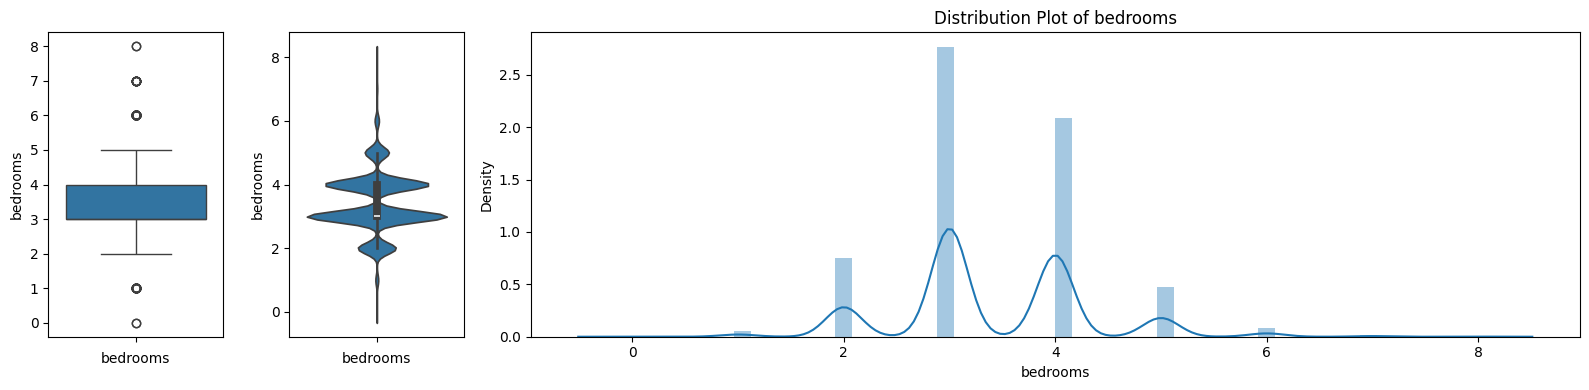

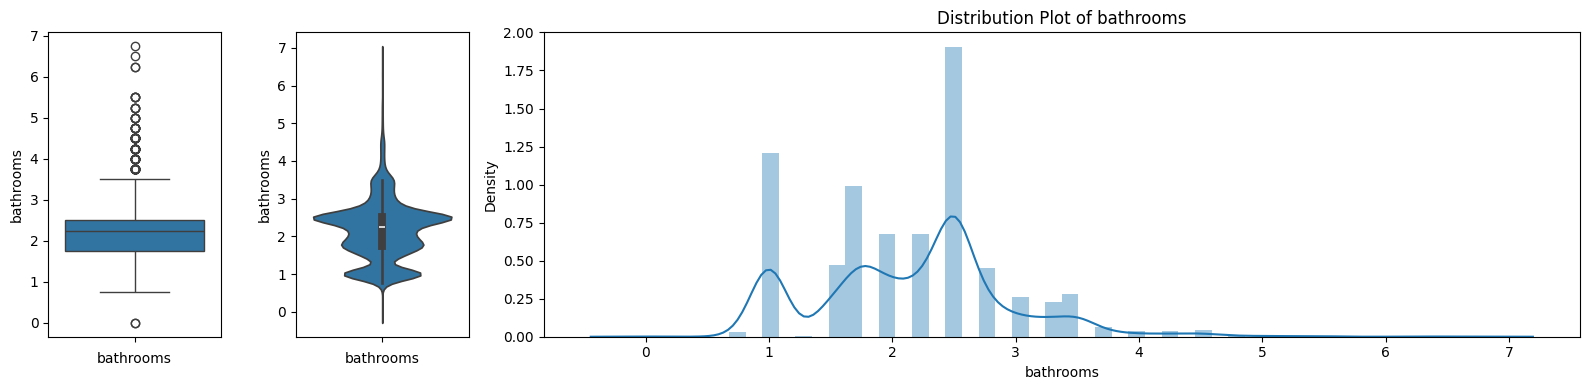

In [24]:
plot_numerical_features(train[numerical_features[1:3]])

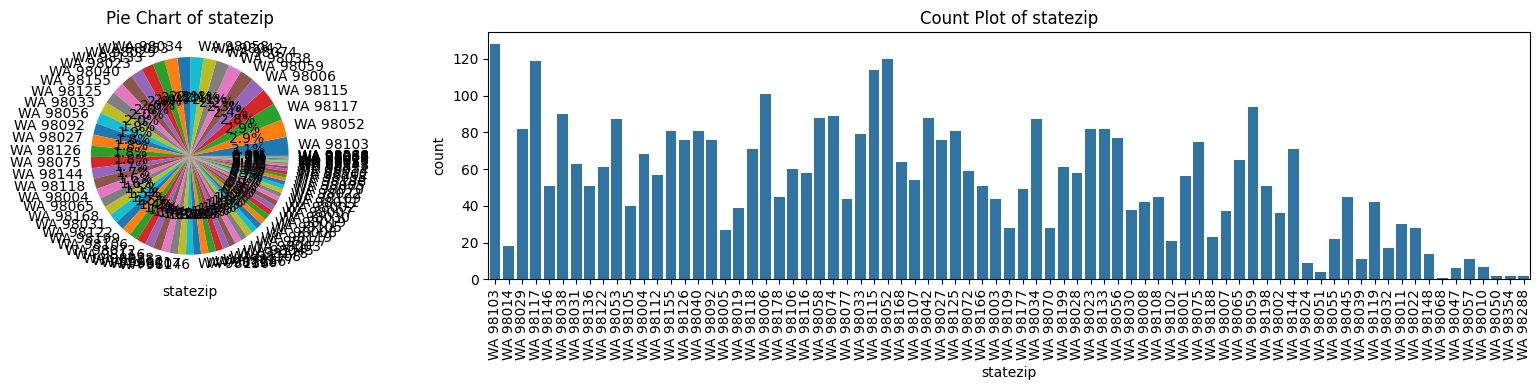

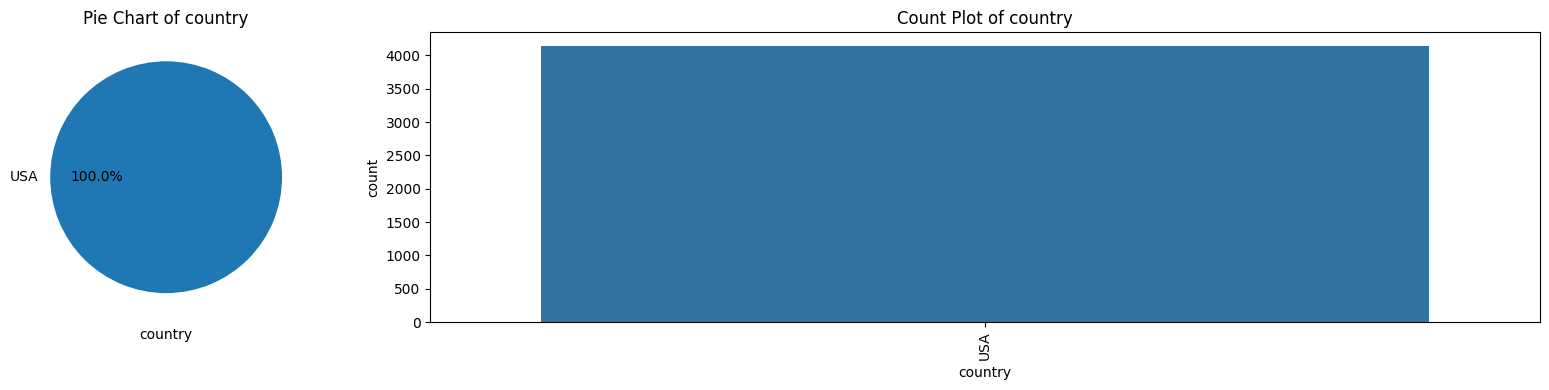

In [26]:
plot_categorical_features(train[categorical_features[3:5]])

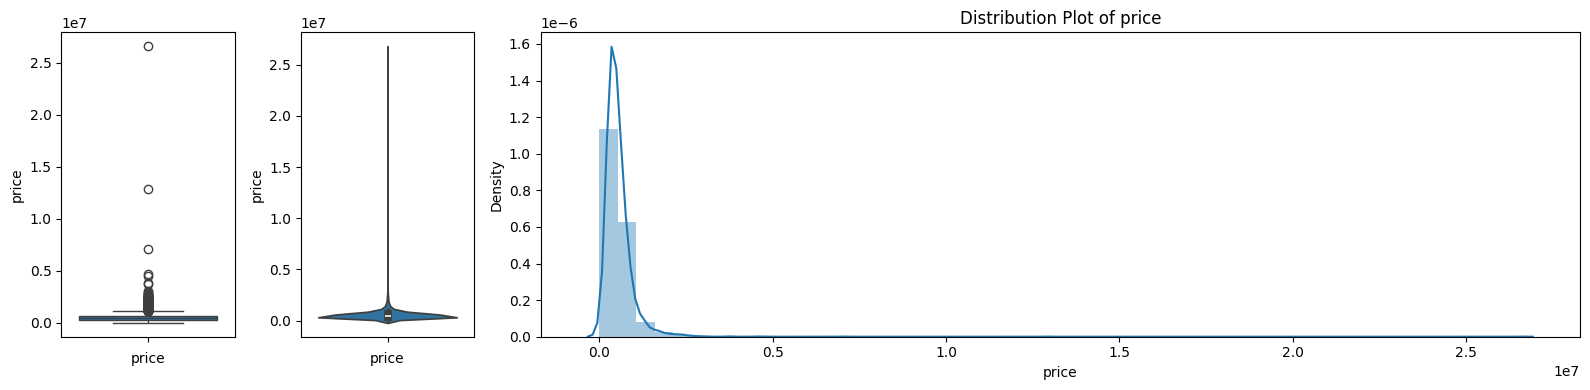

count    4.140000e+03
mean     5.530629e+05
std      5.836865e+05
min      0.000000e+00
25%      3.200000e+05
50%      4.600000e+05
75%      6.591250e+05
max      2.659000e+07
Name: price, dtype: float64

In [27]:
target_feature = "price"
plot_numerical_features(train[[target_feature]])
train['price'].describe()


Remove top 1% outliers
clean the plots instantly.

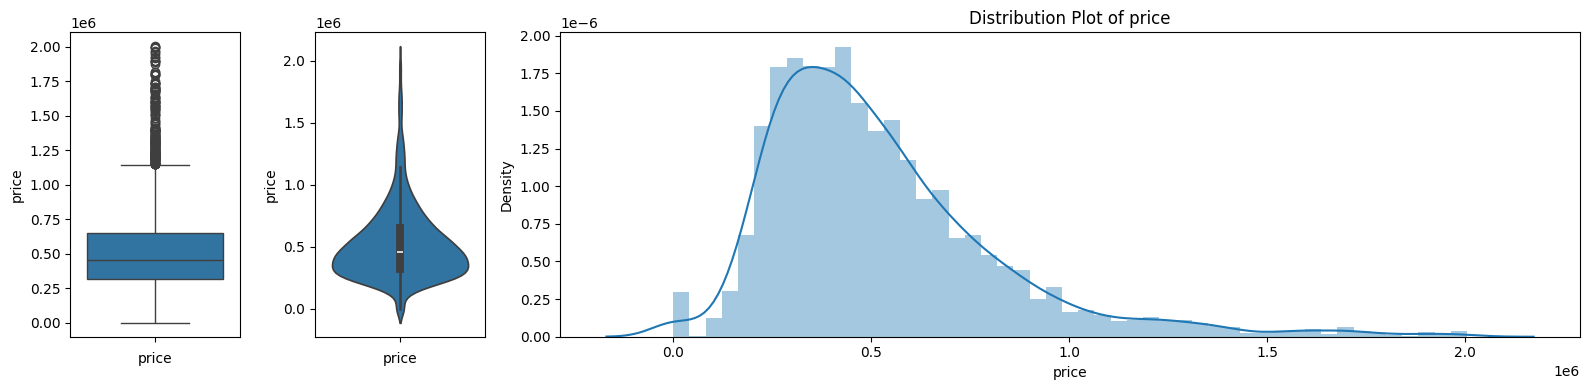

In [28]:
q99 = train['price'].quantile(0.99)
clean_df = train[train['price'] <= q99]

plot_numerical_features(clean_df[['price']])


Log transform price
for distribution normal and perfect for ML.

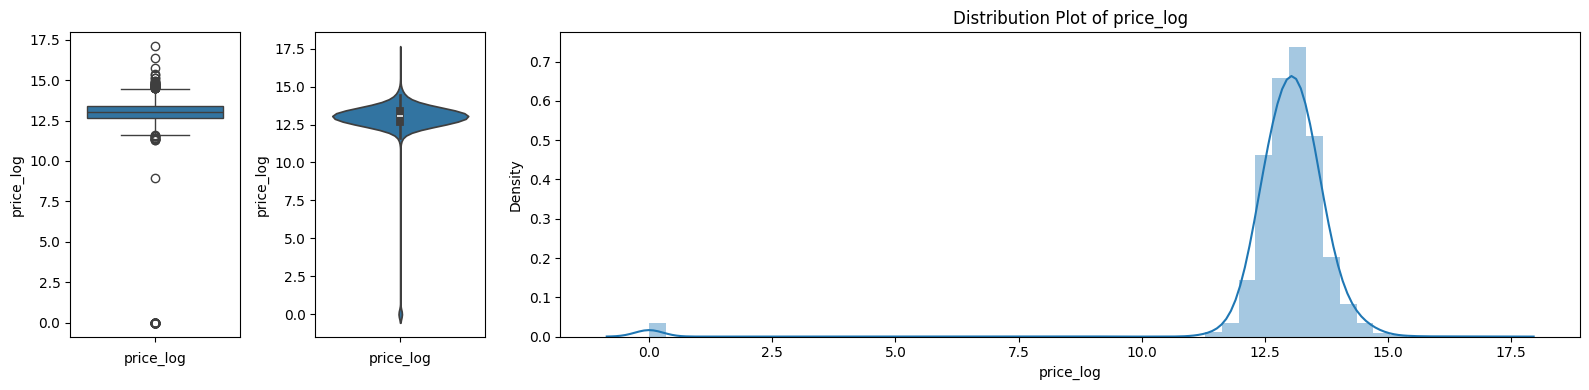

In [29]:


train['price_log'] = np.log1p(train['price'])
plot_numerical_features(train[['price_log']])


Clip extreme values

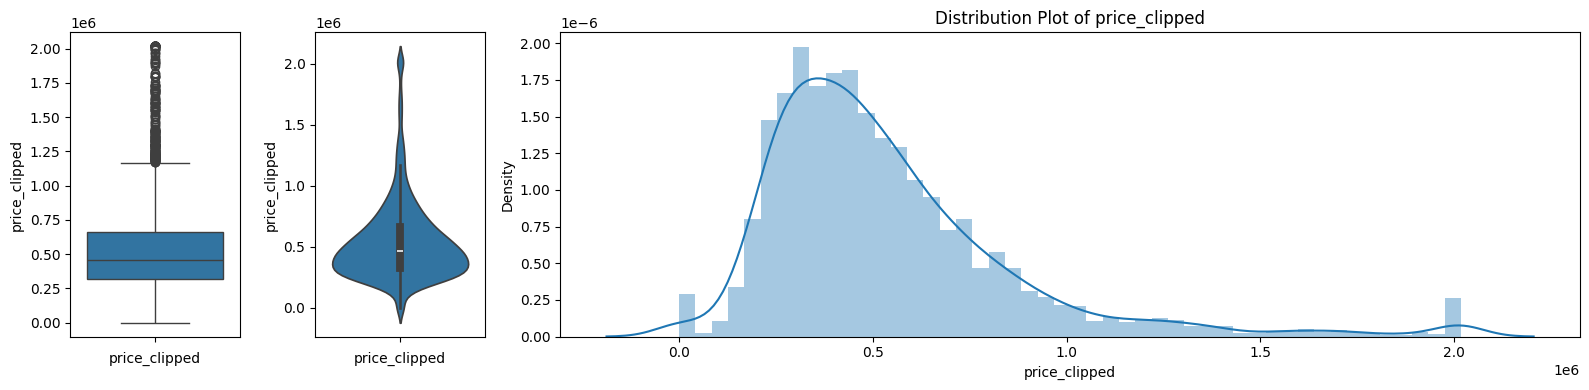

In [30]:
train['price_clipped'] = train['price'].clip(upper=train['price'].quantile(0.99))
plot_numerical_features(train[['price_clipped']])


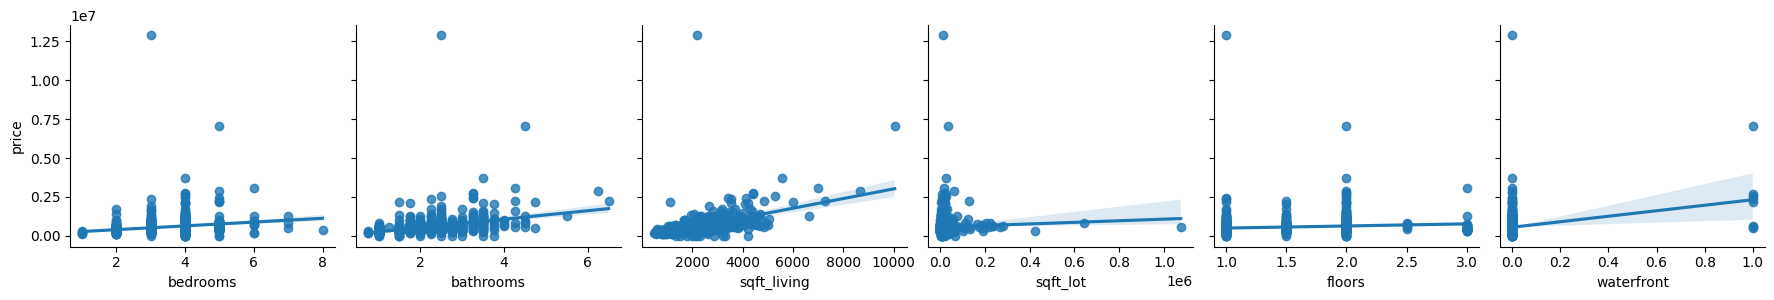

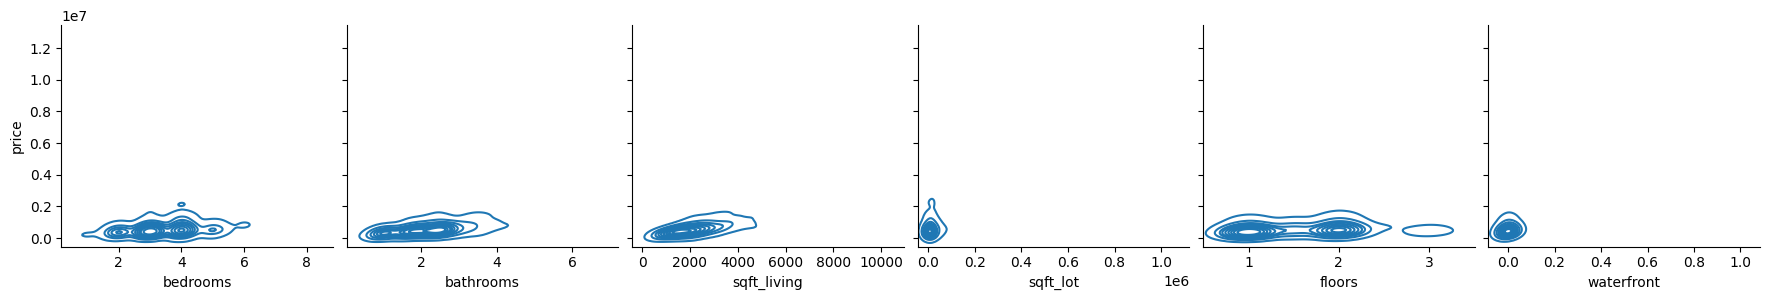

In [31]:
plot_features_correlation(train, numerical_features[1:7], target_feature, plot_kinds=['reg', 'kde'])

In [32]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,9,"['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']"
1,float64,6,"['price', 'bedrooms', 'bathrooms', 'floors', 'price_log', 'price_clipped']"
2,object,5,"['date', 'street', 'city', 'statezip', 'country']"


In [34]:
from sklearn.preprocessing import LabelEncoder

def encode_str_features(df):
    df = df.copy()
    categorical_features = get_categorical_features(df)
    label_encoder = LabelEncoder()
    for col in categorical_features:
        df[col] = label_encoder.fit_transform(df[col])
    
    return df

In [35]:
train = encode_str_features(train)
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_log,price_clipped
0,5,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,3962,34,47,0,12.837347,376000.0
1,5,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,2491,7,10,0,13.592368,800000.0
2,5,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,3511,15,17,0,14.621490,2018420.0
3,5,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,3762,34,56,0,12.688502,324000.0
4,6,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,177,34,65,0,13.217494,549900.0


In [36]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,14,"['date', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']"
1,float64,6,"['price', 'bedrooms', 'bathrooms', 'floors', 'price_log', 'price_clipped']"


<a id="step-1.3"></a>
## Step 1.3: Feature engineering
This step will construct new features based on existing ones. The importance of feature engineering lies in its ability to enhance the predictive power of machine learning models by creating informative, relevant, and discriminative features.

In [41]:
def add_columns(df):
    df = df.copy()
    df["SqFtPerRoom"]        = df["GrLivArea"] / (df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"] + df["KitchenAbvGr"])
    df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
    df['Total_Bathrooms']    = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df["HighQualSF"]         = df["1stFlrSF"] + df["2ndFlrSF"]
    df['TotalSF']            = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Age']                = df['YrSold'] - df['YearBuilt']
    
    return df

In [43]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,14,"['date', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']"
1,float64,6,"['price', 'bedrooms', 'bathrooms', 'floors', 'price_log', 'price_clipped']"


<a id="step-1.4"></a>
## Step 1.4: Process feature skew
Processing feature skew involves addressing the asymmetry or lack of symmetry in the distribution of feature values within a dataset. Skewed features can adversely affect the performance of machine learning models, particularly those sensitive to the distribution of data, such as linear regression. To mitigate skewness, various techniques can be employed, including logarithmic or square root transformations to reduce the influence of outliers and make the distribution more symmetrical. 

In [47]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()

def get_skewed_features(df, skewed_threshold=0.75):
    df = df.copy()
    numerical_features = get_numerical_features(df)
    skewed = df[numerical_features].apply(lambda x: x.skew())
    skewed = skewed.sort_values(ascending=False)
    skewed = skewed.reset_index()
    skewed.columns = ['Feature', 'Skew']
    skewed_features = list(skewed[abs(skewed['Skew']) > skewed_threshold]['Feature'])
    non_skewed_features = list(set(numerical_features)-set(skewed_features))
    return skewed_features, non_skewed_features


def transform_skewed_features(df, skewed_features):
    df = df.copy()
    for col in skewed_features:
        df[col] = np.log1p(df[col])
    
    return df

def transform_non_skewed_features(df, non_skewed_features):
    df = df.copy()
    for col in non_skewed_features:
        df[col] = standardScaler.fit_transform(df[[col]])
    return df